In [12]:
import torch
from cheetah import Segment, Quadrupole, Drift, ParticleBeam, ParameterBeam
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(3.0),
    alpha_x=torch.tensor(-10.0),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(3.0),
    alpha_y=torch.tensor(-5.0),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(1.0e6),
)

beamline = Segment(
            [
                Quadrupole(name="Q0", length=torch.tensor(0.1)),
                Drift(length=torch.tensor(1.0)),
            ]
        )

k_vals = torch.linspace(-100.0, 100.0, 15)
k_vals = torch.cat((k_vals, 500.0 * torch.ones(1)))
beamline.Q0.k1 = k_vals

output = beamline.track(beam)


In [13]:
output.x.shape

torch.Size([16, 100000])

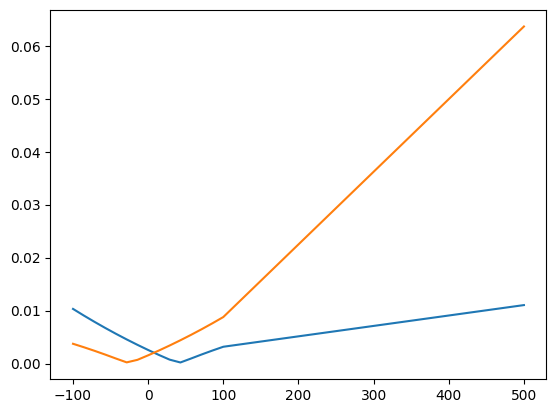

In [14]:
plt.plot(k_vals.numpy(), output.x.std(dim=1).numpy())
plt.plot(k_vals.numpy(), output.y.std(dim=1).numpy())

In [15]:
from scipy.stats import cauchy
images = []
n_bins = 250
resolution = 0.04 / n_bins
for i in range(len(k_vals)):
    images.append(
        np.histogram2d(
            output.x[i].numpy(),
            output.y[i].numpy(),
            bins=[n_bins,n_bins],
            range=np.array([[-0.25,1.75], [-1., 1.]])*resolution * n_bins / 2,
        )[0]
    )

    # add noise to the image
    images[i] += np.abs(cauchy.rvs(loc=0, scale=0.5, size=images[i].shape))*0.3 + np.abs(np.random.normal(loc=0, scale=30, size=images[i].shape))
    images[i] = np.clip(images[i], 0, 1024).astype(np.uint16)


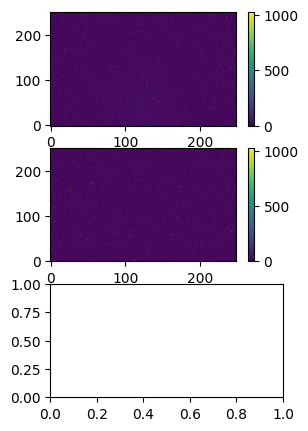

In [16]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, figsize=(3, 5))
for i, ele in enumerate([images[0],images[-1]]):
    c = ax[i].imshow(ele, origin="lower")
    fig.colorbar(c, ax=ax[i])
    ax[i].set_aspect("auto")

In [17]:
from lcls_tools.common.image.processing import ImageProcessor
image_processor = ImageProcessor()
image_processor

ImageProcessor(roi=None, background_image=None, threshold=0.0, gaussian_filter_size=None, median_filter_size=None)

[nan nan] [nan nan]
[19.05822688         nan] [123.60490347          nan]
[123.60490347          nan] [19.05822688         nan]
[16.19716342         nan] [125.47541001          nan]
[125.47541001          nan] [16.19716342         nan]
[11.24046005         nan] [124.37126244          nan]
[124.37126244          nan] [11.24046005         nan]
[6.49537841        nan] [124.1804224         nan]
[124.1804224         nan] [6.49537841        nan]
[2.79908043        nan] [124.5014063         nan]
[124.5014063         nan] [2.79908043        nan]
[4.98820817        nan] [124.4578073         nan]
[124.4578073         nan] [4.98820817        nan]
[10.09982033         nan] [124.93895363          nan]
[124.93895363          nan] [10.09982033         nan]
[15.56004067 10.86180737] [124.47837461  30.71750408]
[124.47837461  30.71750408] [15.56004067 10.86180737]
[20.88610109  5.1896356 ] [125.52116279  30.97221393]
[125.52116279  30.97221393] [20.88610109  5.1896356 ]
[       nan 2.80819815] [       

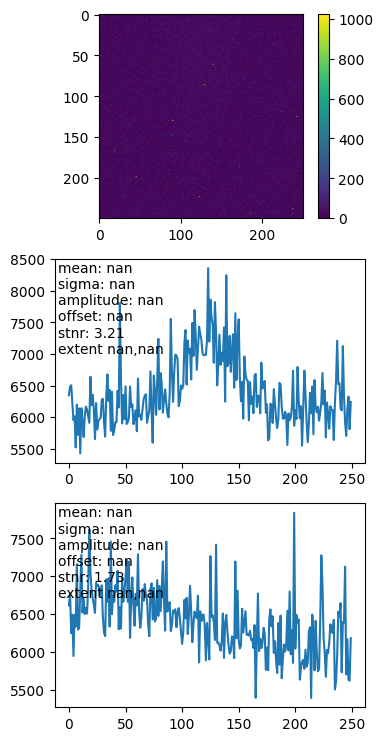

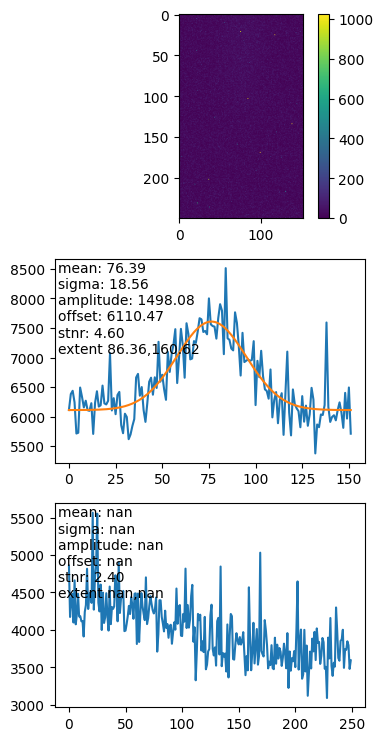

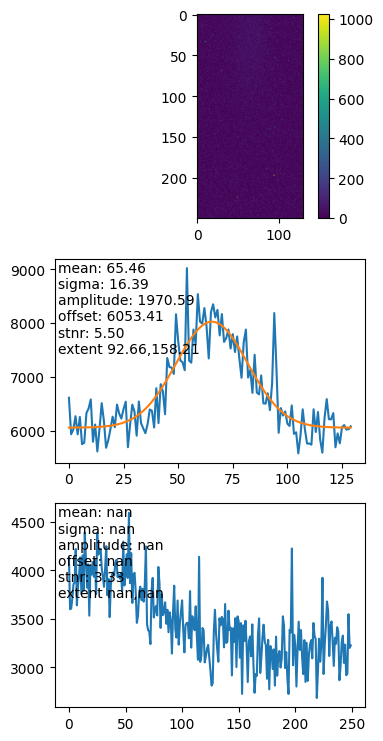

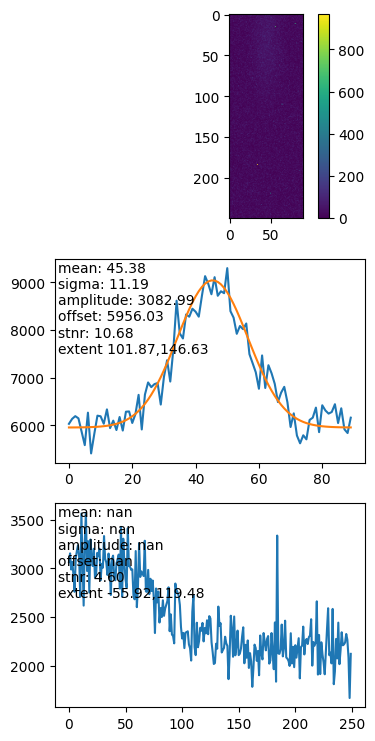

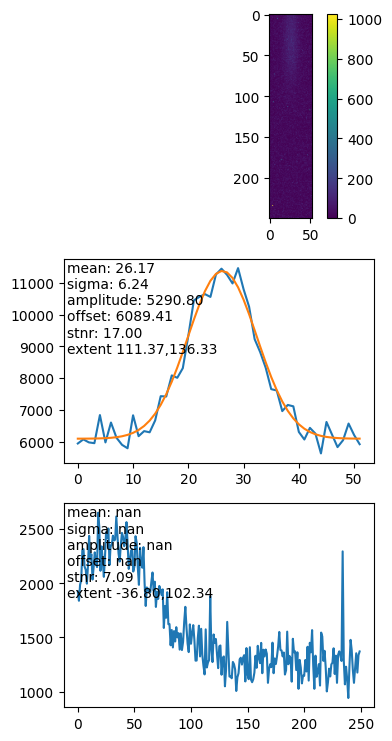

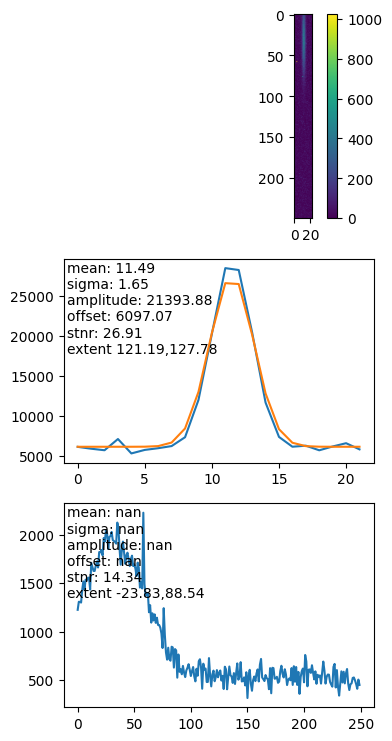

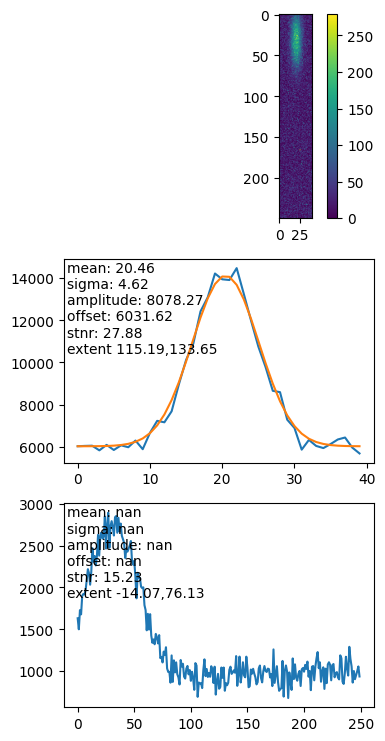

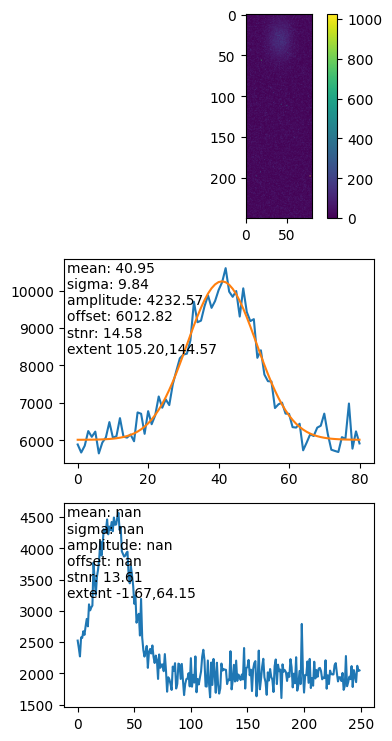

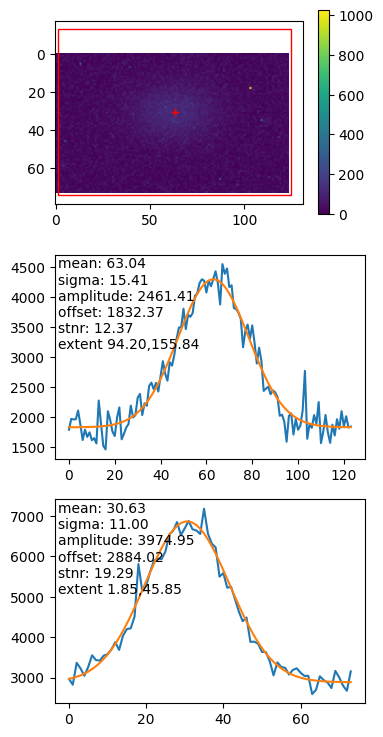

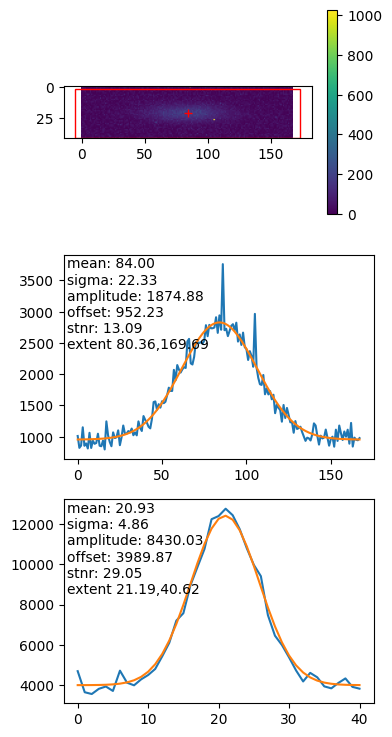

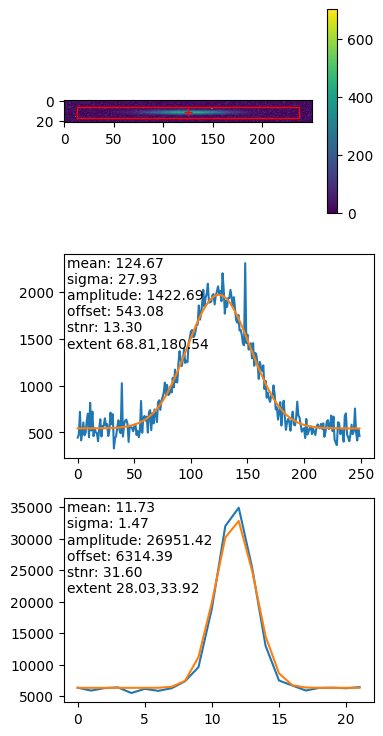

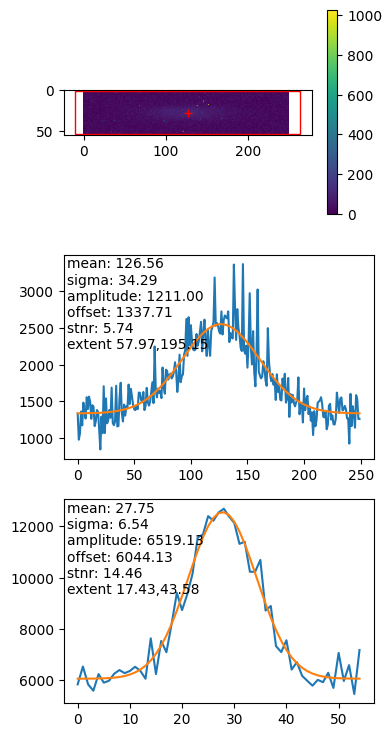

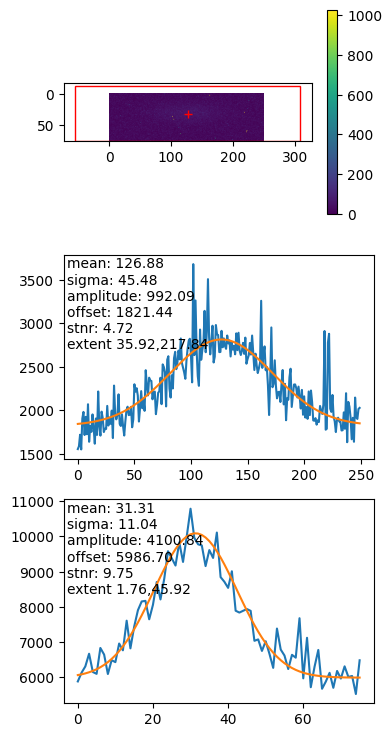

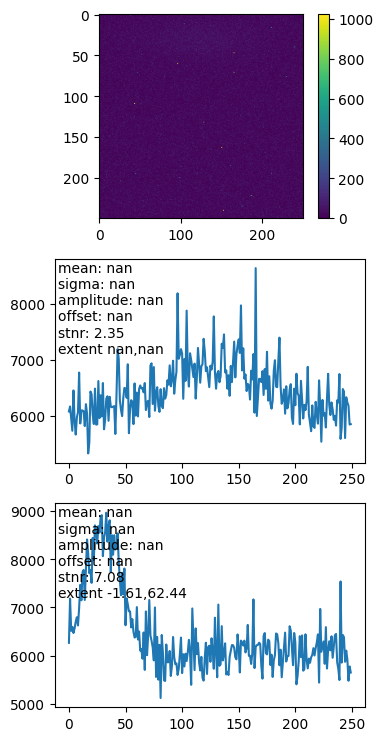

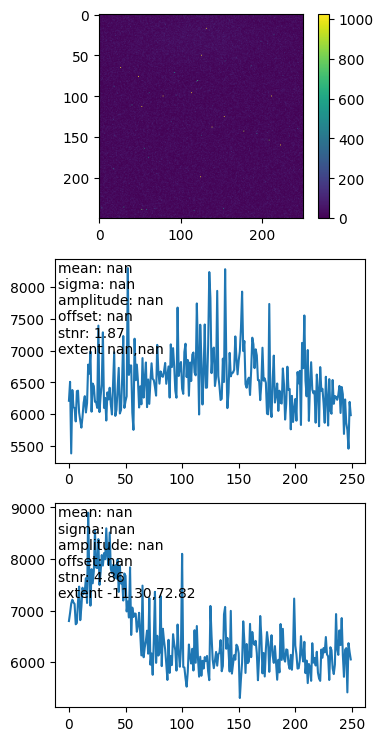

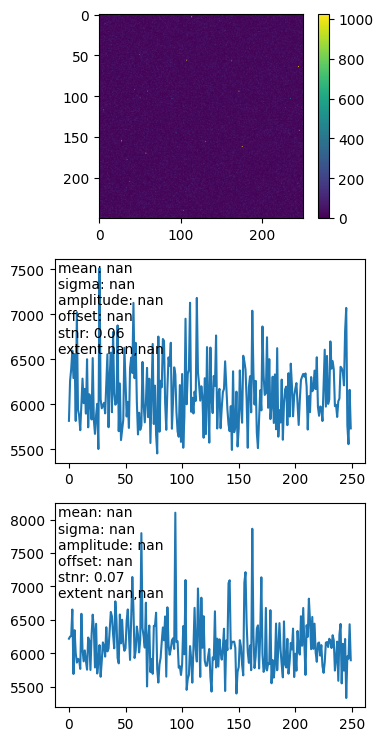

In [18]:
from ml_tto.automatic_emittance.plotting import plot_image_projection_fit
from ml_tto.automatic_emittance.image_projection_fit import ImageProjectionFit, RecursiveImageProjectionFit

#image_projection_fit = ImageProjectionFit()
image_projection_fit = RecursiveImageProjectionFit()

sx = []
sy = []
sx_quality = []
sy_quality = []
stnr = []

for image in images:
    threshold = 0
    image = np.clip(image - threshold, 0, None)

    result = image_projection_fit.fit_image(image_processor.auto_process(image))
    sx.append(result.rms_size[0]*resolution)
    sy.append(result.rms_size[1]*resolution)
    stnr.append(result.signal_to_noise_ratio)
    
    plot_image_projection_fit(result)


Text(0.5, 0, 'K1')

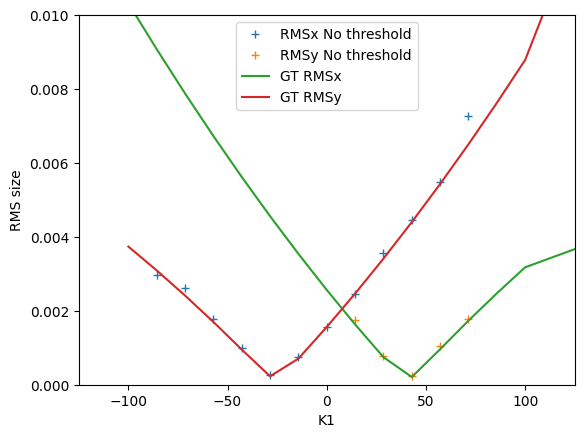

In [20]:
plt.plot(k_vals, sx,"+", label="RMSx No threshold")
plt.plot(k_vals, sy,"+", label="RMSy No threshold")
plt.plot(k_vals, output.x.std(dim=1).numpy(), label="GT RMSx")
plt.plot(k_vals, output.y.std(dim=1).numpy(), label="GT RMSy")
#plt.plot(k_vals, np.array(sx_threshold), label="RMSx Threshold")
#plt.plot(k_vals, np.array(sy_threshold), label="RMSy Threshold")
plt.legend()
plt.xlim(-125, 125)
plt.ylim(0, 0.01)
plt.ylabel("RMS size")
plt.xlabel("K1")

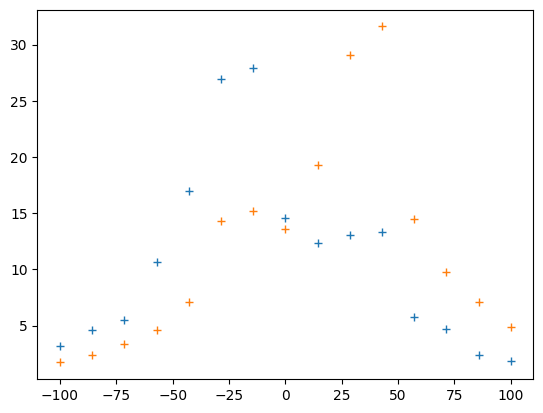

In [21]:
stnr = np.array(stnr)
plt.figure()
plt.plot(k_vals[:-1], stnr[:-1], "+")